In [1]:
# Section 1: Import Dependencies and Setup

import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

# Project imports (your repo)
from danial import model as mh_model
from danial import dataloader

# Configurable paths and parameters
DATA_ROOT = 'dasatet/COD10k-v2'
TEST_IMAGE_DIR = os.path.join(DATA_ROOT, 'Test/Images/Image')
TEST_MASK_DIR = os.path.join(DATA_ROOT, 'Test/GT_Objects/GT_Object')
MODEL_DIR = 'models/ITER2'  # change if needed
CHECKPOINT = os.path.join(MODEL_DIR, 'best.pth')  # default checkpoint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8
THRESH = 0.5
SAVE_RESULTS_DIR = Path('results/validation_first600')
(SAVE_RESULTS_DIR / 'images').mkdir(parents=True, exist_ok=True)

print('Device:', DEVICE)
print('Test images:', TEST_IMAGE_DIR)
print('Checkpoint:', CHECKPOINT)


Device: cpu
Test images: dasatet/COD10k-v2/Test/Images/Image
Checkpoint: models/ITER2/best.pth


In [2]:
# Section 2: Load Trained Model and Segmentation Head

# Initialize model and seg_head (same as train.py)
net = mh_model.Model().to(DEVICE)

seg_head = nn.Sequential(
    nn.Conv2d(64, 1, kernel_size=1),
    nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
).to(DEVICE)

# Load checkpoint
if os.path.exists(CHECKPOINT):
    ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
    loaded = []
    # Try several common key names
    if isinstance(ckpt, dict):
        if 'model_state_dict' in ckpt:
            net.load_state_dict(ckpt['model_state_dict'], strict=False)
            loaded.append('model_state_dict')
        else:
            try:
                net.load_state_dict(ckpt, strict=False)
                loaded.append('direct_state_dict')
            except Exception:
                pass
        if 'seg_head_state_dict' in ckpt:
            seg_head.load_state_dict(ckpt['seg_head_state_dict'], strict=False)
            loaded.append('seg_head_state_dict')
    else:
        # ckpt may be a raw state_dict
        try:
            net.load_state_dict(ckpt, strict=False)
            loaded.append('raw_state_dict')
        except Exception as e:
            print('Failed to load checkpoint:', e)
    print('Loaded keys from checkpoint:', loaded)
    if 'epoch' in ckpt:
        print('Checkpoint epoch:', ckpt.get('epoch'))
    if 'loss' in ckpt:
        print('Checkpoint loss:', ckpt.get('loss'))
else:
    print('WARNING: checkpoint not found at', CHECKPOINT)


/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded keys from checkpoint: ['model_state_dict', 'seg_head_state_dict']
Checkpoint epoch: 187
Checkpoint loss: 0.033576339614356375


In [3]:
# Section 3: Create Validation Dataset

# Build the dataset using the same helper as training
val_dataset = dataloader.SegmentationDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=TEST_MASK_DIR,
    target_size=(224, 224),
    normalize_imagenet=True
)

val_loader = val_dataset.get_dataloader(
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print('Validation samples:', len(val_dataset))


Found 4000 image-mask pairs
Validation samples: 4000


In [4]:
# Section 4: Inference helper and utilities

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])


def tensor_to_image(tensor):
    """Convert a torch tensor (C,H,W) or numpy array to uint8 HxWx3.

    Handles:
    - torch.Tensor with shape (C,H,W) or (1,C,H,W) or (B,C,H,W) (will take first sample)
    - numpy arrays with channel-first or channel-last ordering.
    Raises a helpful error if shape is unexpected.
    """
    # Convert torch -> numpy
    if isinstance(tensor, torch.Tensor):
        arr = tensor.detach().cpu().numpy()
    else:
        arr = np.array(tensor)

    # If batch dimension present, take first sample
    if arr.ndim == 4:
        arr = arr[0]

    # If channel-first expected: (C,H,W)
    if arr.ndim == 3 and arr.shape[0] in (1, 3):
        c, h, w = arr.shape
        img = arr.transpose(1, 2, 0)
    # If channel-last already: (H,W,3) or (H,W,1)
    elif arr.ndim == 3 and arr.shape[2] in (1, 3):
        img = arr
        h, w, c = img.shape
        if c == 1:
            img = np.repeat(img, 3, axis=2)
    else:
        raise ValueError(f"tensor_to_image: unsupported input shape {arr.shape}. Expected (C,H,W) or (H,W,3).")

    # If values are normalized (small floats), unnormalize by ImageNet stats
    if img.dtype == np.float32 or img.dtype == np.float64:
        # assume image is normalized in channel-last float in [0,1] or standardized
        try:
            # Try to reverse ImageNet std/mean if values look standardized (mean near 0)
            if np.abs(img.mean()) < 2.0:
                img = (img * IMAGENET_STD + IMAGENET_MEAN)
        except Exception:
            pass
        img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    else:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def save_mask_image(mask_np, outpath):
    """Save a binary or float mask as a grayscale PNG.

    Accepts mask in shapes: (H,W), (1,H,W), (H,W,1), or boolean.
    """
    arr = np.array(mask_np)
    # Reduce extra dims
    if arr.ndim == 4:
        arr = arr[0]
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[..., 0]

    # Normalize floats to 0-255
    if arr.dtype == np.bool_:
        img = (arr.astype(np.uint8) * 255)
    elif np.issubdtype(arr.dtype, np.floating):
        img = (np.clip(arr, 0.0, 1.0) * 255.0).astype(np.uint8)
    else:
        img = arr.astype(np.uint8)

    Image.fromarray(img).save(str(outpath))


def overlay_image(image_np, mask_np, alpha=0.5, color=(255, 0, 0)):
    """Overlay mask (H,W) on image (H,W,3) and return uint8 image.

    This function is defensive: it will squeeze batch/channel dims on the mask
    and will resize the mask to match the image if necessary.
    """
    img = np.array(image_np).astype(np.float32)
    mask = np.array(mask_np)

    # Squeeze common singletons (B,1,H,W) -> (H,W)
    if mask.ndim == 4:
        mask = mask[0]
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask[..., 0]

    # If mask is channel-first (C,H,W) where C>1, try to reduce to single channel
    if mask.ndim == 3 and mask.shape[0] > 1 and mask.shape[0] <= 4:
        mask = mask[0]

    # Ensure mask is 2D now
    if mask.ndim != 2:
        raise ValueError(f"overlay_image: expected 2D mask but got shape {mask.shape}")

    # If image has no channel dimension, expand
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # Resize mask if necessary
    ih, iw = img.shape[:2]
    mh, mw = mask.shape[:2]
    if (ih, iw) != (mh, mw):
        mask_img = Image.fromarray((np.clip(mask, 0, 1) * 255).astype(np.uint8))
        mask_img = mask_img.resize((iw, ih), resample=Image.NEAREST)
        mask = np.array(mask_img).astype(np.float32) / 255.0

    # Ensure mask is 0..1 float
    if mask.dtype != np.float32 and mask.dtype != np.float64:
        mask = mask.astype(np.float32) / 255.0 if mask.max() > 1 else mask.astype(np.float32)

    mask_2d = mask[..., None]
    mask_col = np.zeros_like(img, dtype=np.float32)
    for c in range(3):
        mask_col[..., c] = mask_2d[..., 0] * float(color[c])

    out = img * (1 - alpha) + mask_col * alpha
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out


def infer_batch(inputs):
    """Run model and segmentation head to produce probability masks [B,1,H,W].

    This function also validates the seg_head output shape and upsamples if needed.
    """
    net.eval()
    seg_head.eval()
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        outputs = net(inputs)
        # net may return tuple/list
        if isinstance(outputs, (list, tuple)) and len(outputs) >= 3:
            _, _, fused_feat = outputs
        else:
            # fallback: assume model returns fused feature directly
            fused_feat = outputs
        seg_pred = torch.sigmoid(seg_head(fused_feat))

        # seg_pred should be [B,1,H,W]; if H/W are small, upsample to target 224x224
        if seg_pred.dim() == 4 and (seg_pred.shape[2] < 32 or seg_pred.shape[3] < 32):
            seg_pred = nn.functional.interpolate(seg_pred, size=(224, 224), mode='bilinear', align_corners=False)
    return seg_pred.cpu()


In [ ]:
# Section 5: Metrics and Batch Validation Loop

import csv

def iou_score(pred_bin, gt_bin, eps=1e-7):
    pred = pred_bin.astype(bool)
    gt = gt_bin.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    if union == 0:
        return 1.0 if inter == 0 else 0.0
    return float(inter) / (union + eps)


def f1_score(pred_bin, gt_bin, eps=1e-7):
    pred = pred_bin.astype(bool).sum()
    gt = gt_bin.astype(bool).sum()
    tp = np.logical_and(pred_bin, gt_bin).sum()
    # precision = tp / (pred + eps); recall = tp / (gt + eps)
    prec = tp / (pred + eps)
    rec = tp / (gt + eps)
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec + eps)


def mae_score(pred, gt):
    return float(np.abs(pred.astype(float) - gt.astype(float)).mean())

# Run validation loop and save per-image metrics
results = []
net.eval(); seg_head.eval()

pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation')
for batch_idx, batch in pbar:
    try:
        inputs, targets = batch
    except Exception:
        # If dataset returns different structure, try unpacking
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            inputs, targets = batch[0], batch[1]
        else:
            raise
    probs = infer_batch(inputs)  # [B,1,H,W]
    probs_np = probs.squeeze(1).numpy()  # [B,H,W]
    targets_np = targets.squeeze(1).cpu().numpy() if isinstance(targets, torch.Tensor) else np.array(targets)

    batch_size = probs_np.shape[0]
    for i in range(batch_size):
        prob = probs_np[i]
        gt = targets_np[i]
        pred_bin = (prob >= THRESH).astype(np.uint8)
        gt_bin = (gt >= 0.5).astype(np.uint8)
        iou = iou_score(pred_bin, gt_bin)
        f1 = f1_score(pred_bin, gt_bin)
        mae = mae_score(prob, gt)
        idx_global = batch_idx * BATCH_SIZE + i
        # Try to derive a filename from dataset if possible
        fname = None
        try:
            # many dataset implementations store image paths under .images or .image_paths
            if hasattr(val_dataset, 'image_paths'):
                fname = Path(val_dataset.image_paths[idx_global]).name
            elif hasattr(val_dataset, 'images'):
                fname = Path(val_dataset.images[idx_global]).name
            elif hasattr(val_dataset, 'file_list'):
                fname = Path(val_dataset.file_list[idx_global]).name
        except Exception:
            fname = f'img_{idx_global:06d}.png'
        if fname is None:
            fname = f'img_{idx_global:06d}.png'

        # Save predicted mask and overlay image
        try:
            # Get original input image for visualization
            inp_img = tensor_to_image(inputs[i])
            mask_uint8 = (pred_bin * 255).astype(np.uint8)
            mask_path = SAVE_RESULTS_DIR / 'images' / (Path(fname).stem + '_pred_mask.png')
            overlay_path = SAVE_RESULTS_DIR / 'images' / (Path(fname).stem + '_overlay.png')
            save_mask_image(mask_uint8, mask_path)
            overlay = overlay_image(inp_img, pred_bin, alpha=0.4)
            Image.fromarray(overlay).save(overlay_path)
        except Exception as e:
            # If saving fails, continue but note the failure
            print('Warning: saving visualization failed for', fname, '-', e)

        results.append({
            'filename': str(fname),
            'index': int(idx_global),
            'iou': float(iou),
            'f1': float(f1),
            'mae': float(mae)
        })

# Save CSV
metrics_csv = SAVE_RESULTS_DIR / 'metrics.csv'
pd.DataFrame(results).to_csv(metrics_csv, index=False)

# Print aggregated metrics
if len(results) > 0:
    df = pd.DataFrame(results)
    print('Validation results saved to', metrics_csv)
    print('Mean IoU: {:.4f}, Mean F1: {:.4f}, Mean MAE: {:.6f}'.format(df['iou'].mean(), df['f1'].mean(), df['mae'].mean()))
else:
    print('No results produced')


Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Validation results saved to results/validation_first600/metrics.csv
Mean IoU: 0.3337, Mean F1: 0.0599, Mean MAE: 0.050603


In [6]:
# Debug shapes in forward pass
with torch.no_grad():
    # Run a single sample through to debug shapes
    sample_input = next(iter(val_loader))[0][:1].to(DEVICE)  # take 1st image of batch
    print('Input shape:', sample_input.shape)
    
    # Run through backbone (F3)
    net.eval()
    x = sample_input
    f3_conv = net.f3(x)
    print('F3 output shape:', f3_conv.shape)
    
    # Run through SPG and PRM
    spg_out = net.spg(f3_conv)
    print('SPG output shape:', spg_out.shape)
    prm_out = net.prm(f3_conv, spg_out)
    print('PRM output shape:', prm_out.shape)
    
    # Debug PreFCS internals
    if hasattr(net.pre_fcs, 'interpolate'):
        # If pre_fcs has interpolation, what size does it use?
        print('PreFCS interpolation size:', getattr(net.pre_fcs, 'size', None))
    
    # Try to identify where size 64 and 8 come from
    print('\nSuspect tensors (looking for 64 or 8 in any dimension):')
    for name, tensor in [('f3_conv', f3_conv), ('spg_out', spg_out), ('prm_out', prm_out)]:
        if any(s in (64, 8) for s in tensor.shape):
            print(f'{name}: {tensor.shape}')

Input shape: torch.Size([1, 3, 224, 224])


AttributeError: 'Model' object has no attribute 'f3'

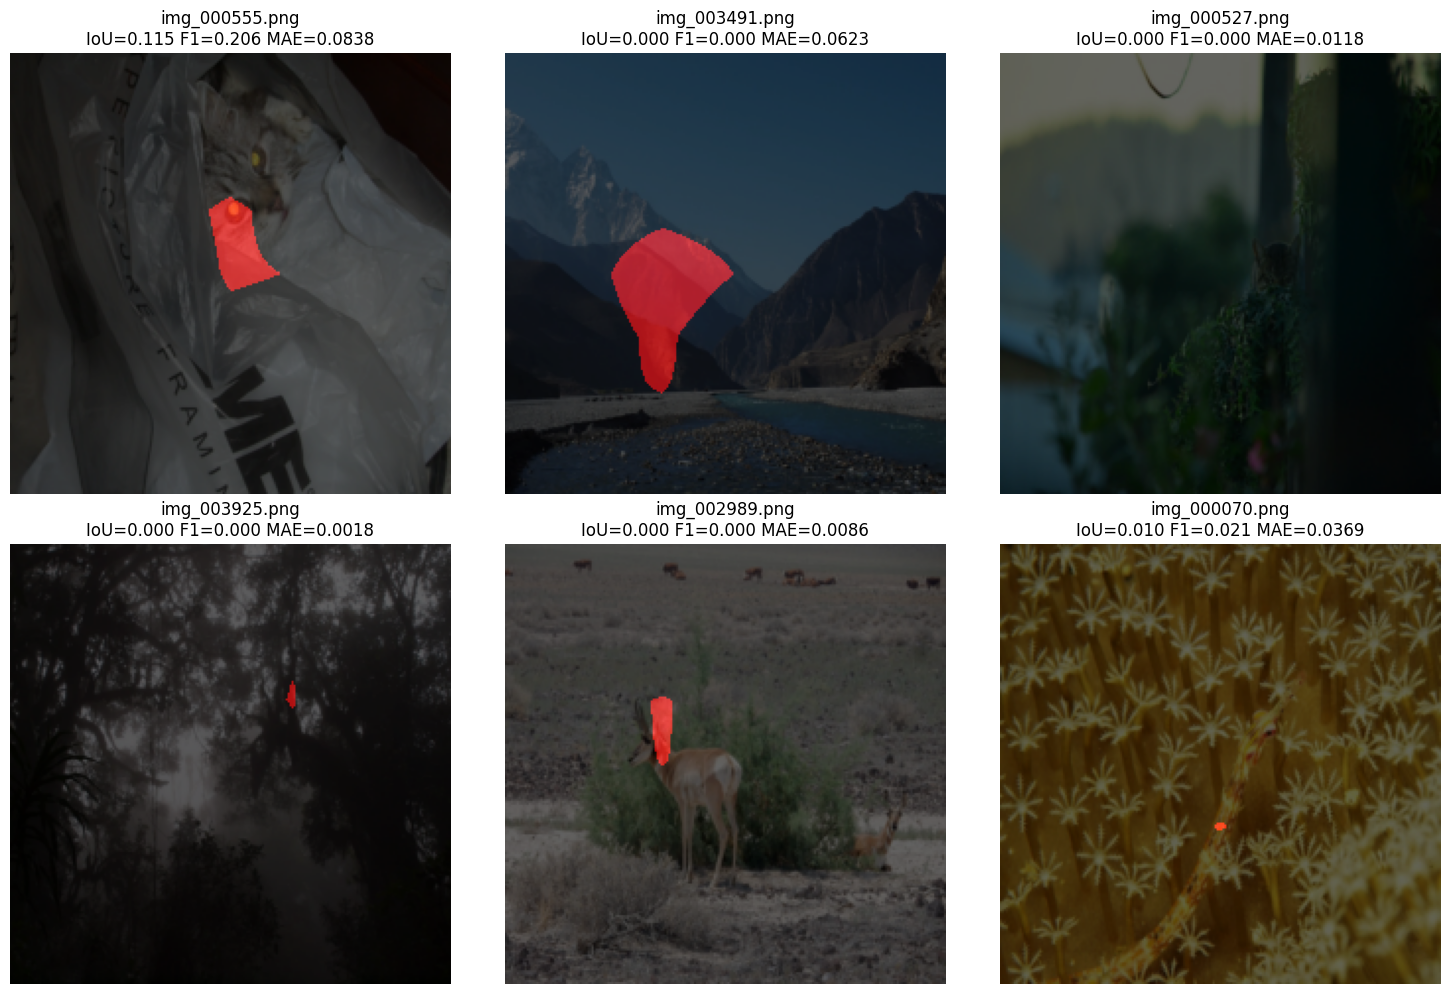

In [8]:
# Section 6: Visualize some predictions

import matplotlib.pyplot as plt
from math import ceil

# Load CSV if needed
metrics_path = SAVE_RESULTS_DIR / 'metrics.csv'
if metrics_path.exists():
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(results)

# pick a few random examples
n_show = 6
if len(metrics_df) == 0:
    print('No examples to show')
else:
    samples = metrics_df.sample(n=min(n_show, len(metrics_df)), random_state=42)
    fig_rows = ceil(len(samples) / 3)
    fig, axes = plt.subplots(fig_rows, 3, figsize=(15, 5 * fig_rows))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, samples.iterrows()):
        fname = row['filename']
        stem = Path(fname).stem
        # attempt to find files saved earlier
        orig_idx = int(row.get('index', 0))
        try:
            # Try to open original input via dataset if path available
            if hasattr(val_dataset, 'image_paths'):
                img_path = val_dataset.image_paths[orig_idx]
                orig = np.array(Image.open(img_path).convert('RGB').resize((224,224)))
            else:
                # fallback to using saved overlay
                overlay_path = SAVE_RESULTS_DIR / 'images' / (stem + '_overlay.png')
                orig = np.array(Image.open(overlay_path).convert('RGB'))
        except Exception:
            orig = np.zeros((224,224,3), dtype=np.uint8)
        try:
            gt_path = SAVE_RESULTS_DIR / 'images' / (stem + '_gt.png')
            # we didn't save ground-truth by default; try to get from dataset
            if hasattr(val_dataset, 'mask_paths'):
                mask_path = val_dataset.mask_paths[orig_idx]
                gt = Image.open(mask_path).convert('L').resize((224,224))
                gt = np.array(gt)
            else:
                gt = None
        except Exception:
            gt = None
        try:
            pred_path = SAVE_RESULTS_DIR / 'images' / (stem + '_pred_mask.png')
            pred = np.array(Image.open(pred_path).convert('L'))
        except Exception:
            pred = None

        ax.imshow(orig)
        title = f"{fname}\nIoU={row['iou']:.3f} F1={row['f1']:.3f} MAE={row['mae']:.4f}"
        ax.set_title(title)
        ax.axis('off')
        # if pred available, overlay a contour
        if pred is not None:
            # show a translucent mask overlay
            overlay = overlay_image(orig, (pred>127).astype(np.uint8), alpha=0.35)
            ax.imshow(overlay)
    # hide unused axes
    for j in range(len(samples), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


# Section 7: Notes & How to run

# Quick usage notes:
# 1) Open this notebook in Jupyter or VS Code.
# 2) Adjust `MODEL_DIR` and `CHECKPOINT` if you want to use a different checkpoint (e.g. 'last.pth' or 'checkpoint_epoch_600.pth').
# 3) Change BATCH_SIZE if GPU memory is limited.
# 4) If you want to save ground-truth crops/visualizations, add saving logic in the validation loop.

print('Notebook ready. Run cells top-to-bottom to perform validation.')
